In [1]:
import sys
sys.path.append("..")

import math
import logging
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from scripts.src.hierarchy import *
from scripts.src.processing import *
from scripts.src.label_utils import *
from scripts.src.data_reading import *

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

logging.basicConfig(level=logging.INFO )

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [2]:
num_gpus = torch.cuda.device_count()
device = torch.device("cuda" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")
device

device(type='cpu')

In [3]:
n_components = 300

In [4]:
def _check_data(y):

    class_labels = np.unique(y)
    num_tasks = len(class_labels)
    num_examples = y.shape[0]
    if num_tasks == 1:
        raise ValueError("The number of classes has to be greater than one.")
    elif num_tasks == 2:
        if 1 in class_labels and -1 in class_labels:
            num_tasks = 1
            class_labels = np.array([-1, 1])
        elif 1 in class_labels and 0 in class_labels:
            num_tasks = 1
            class_labels = np.array([0, 1])
        else:
            raise ValueError("Unable to decide postive label")

    lbin = LabelBinarizer(neg_label=-1, pos_label=1)
    lbin.fit(class_labels)
    y_bin = lbin.transform(y)
    return y_bin, class_labels, num_tasks

In [22]:
class DatasetIterator:
    def __init__(self, datafile, catfile, subsample, is_directed, fmt):
        self.datafile = datafile
        
        if fmt == "libsvm":
            self.lib_data = LIBSVM_Reader(self.datafile, True, n_components, subsample)
            self.df = self.lib_data.data_df
            self.MLmatrix = self.lib_data.label_matrix
            self.MLbin = self.lib_data.binarizer
            self.rev_df = self.lib_data.rev_df
        elif fmt =="raw":
            self.raw_df = CSV_Reader(self.datafile, subsample)
            self.df = self.raw_df.data_df
            self.rev_df = self.raw_df.rev_df
        
        self.cat = HierarchyUtils(catfile, [n_components,1], is_directed, False)
#         self.wn = self.cat.generate_vectors(device = device, neighbours = True)

    def read_df(self, idx):
        i = self.df.index[self.df["doc_id"] == idx][0]
        return self.df.at[i, "doc_vector"], self.df.at[i, "doc_labels"], i
    
    def __getitem__(self, _id):
        return self.read_df(_id)

    def __iter__(self):
        for _id in self.df.index:
            yield self[_id]

class DatasetModule(Dataset):

    def __init__(self, root_location, cat_file, subsample, is_directed, fmt):
        
        self.iter = DatasetIterator(root_location, cat_file, subsample, is_directed, fmt)
        
        class_labels = self.iter.MLbin.classes_
        temp = {}
        for j, i in enumerate(list(class_labels)):
            if i not in temp:
                temp[i] = j

        self.small_mapper = temp
        
        self.lmbda = self.lambda_param()
        
    def lambda_param(self):
        wn = self.iter.cat.generate_vectors(device = device, neighbours=True)
        w_n = list2tensor(wn[0].values())
        w_pi = list2tensor(wn[1].values())

        norm2 = torch.norm(w_n-w_pi, 2)
        lmbda = 0.5*norm2**2
        return lmbda

    def encode_labels(self, labels, idx):
        for each_label in labels:
            if each_label in self.iter.cat.T_leaves:
                y = self.iter.MLmatrix[idx].toarray().flatten()
                y_in, _, _ = _check_data(y)
                y_in = y_in.flatten()
                break
            else:
                y_in = np.ones((len(self.small_mapper),))*-1
        y_in = torch.as_tensor(y_in, dtype=torch.float32, device=device)
        return y_in

    def __len__(self):
        return len(self.iter.df)

    def __load(self, idx):
        doc_vec, doc_labels, doc_id = self.iter[idx]
        yin = self.encode_labels(doc_labels, idx)
        return doc_vec, doc_labels, doc_id, yin

    def __getitem__(self, idx):
        return self.__load(idx)

In [ ]:
train_data = DatasetModule("../rcv1.tar/RCV1_1/rcv1.train.ltc.svm", "../rcv1.tar/RCV1_1/rcv1.topic.hierarchy", False, False, "libsvm")

In [ ]:
test_data = DatasetModule("../rcv1.tar/RCV1_1/rcv1.test.ltc.svm", "../rcv1.tar/RCV1_1/rcv1.topic.hierarchy", 0.2, False, "libsvm")

In [ ]:
train_data = DatasetModule("../swiki/data/train_remapped.txt", "../swiki/data/cat_hier.txt", False, True, "libsvm")

In [ ]:
test_data = DatasetModule("../swiki/data/test_remapped.txt", "../swiki/data/cat_hier.txt", False, False, "libsvm")

In [25]:
batch_size = 99
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

In [26]:
train_iter = iter(train_loader)
doc_vec, doc_labels, _id, yy =  train_iter.next()

In [27]:
print(doc_vec.shape)
print("*"*50)
print(doc_labels[0])
print("~"*50)
print(yy[0])
print("-"*50)
# print(yy[1][0])
print("_"*50)
print(_id)
print("^"*50)

torch.Size([40, 300])
**************************************************
tensor([10, 10,  5, 71, 95,  5, 71, 99, 35, 71, 96,  5,  5,  5, 99,  5, 71, 71,
        19, 28,  5,  5,  2, 71, 35, 71, 99, 71, 22,  5, 31, 94, 71, 59,  3, 15,
        34,  2, 71,  1])
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,
         1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.])
--------------------------------------------------
__________________________________________________
tensor([ 6736,  584

In [28]:
torch.version.cuda
torch.backends.cudnn.version()
torch.backends.cudnn.benchmark = True

In [29]:
class Node(nn.Module):
    def __init__(self, weight_dims):
        super().__init__()
        w_n = torch.FloatTensor(*weight_dims)

        weights_n = nn.init.xavier_normal_(w_n, gain = nn.init.calculate_gain('relu'))
        weights_pi = torch.Tensor([nn.init.random.random()*1e-2])
        
        self.w = nn.Parameter(weights_n)    
        self.w_pi = nn.Parameter(weights_pi) + self.w
        
    def forward(self, x_i):
        tanh = torch.tanh(x_i.matmul(self.w))
        return tanh
    
    def L2_reg(self):
        norm = torch.norm((self.w-self.w_pi), 2)
        sol = 0.5*norm**2
        return sol
    
class HRLR(nn.Module):
    def __init__(self, n_components, num_tasks):
        super().__init__()
        self.linear = Node([n_components, num_tasks])

    def forward(self, yin, x_i):
        # for each node, compute forward, and do a -1 +1 threshold to get classes
        score = self.linear.forward(x_i)
        self.fwd_pass = - yin * score
        return self.fwd_pass
    
    def compute_loss_leaf(self):
        loss = torch.log2(1+torch.exp(self.fwd_pass))
        l2_reg = self.linear.L2_reg()
        value = loss.mean()
        return value
    

In [46]:
def save_entire_model(model, path):
    torch.save(model, path)

def save_model_state(model, path):
    torch.save(model.state_dict(), path)

In [30]:
def reset_model():
    '''
    training performance is affected by large `n_tasks` size which basically increases the number of parameters to tune.
    as parameter dimension increases, weight decay also needs to be increased. what is the relation between param dim 
    and weight decay?
    '''

    # Hyper Parameters 
    num_epochs = 5
    learning_rate = 0.001 
    n_tasks = len(train_data.iter.MLbin.classes_) #batch_size

    model = HRLR(n_components, n_tasks)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=model.linear.L2_reg().item())

#     optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    
    return model, optimizer, num_epochs

In [31]:
model, optimizer, num_epochs = reset_model()

In [53]:
list(model.parameters())[0].data

tensor([[-1.9715e-02, -1.9600e-02, -1.8655e-02,  ..., -1.9813e-02,
         -1.9029e-02, -1.2243e-02],
        [-6.5944e-04, -1.2343e-03, -3.9871e-04,  ..., -1.1730e-03,
          3.7422e-04, -2.2475e-03],
        [ 2.4277e-03,  2.7103e-03,  2.5467e-03,  ...,  1.6826e-03,
          2.2863e-03,  1.1948e-03],
        ...,
        [ 4.7320e-05,  1.0373e-04,  6.9379e-05,  ...,  3.5816e-05,
          1.4818e-04,  4.2904e-04],
        [-1.7985e-04, -1.1426e-04, -4.1487e-04,  ..., -1.0698e-04,
         -8.1758e-05, -3.7880e-04],
        [-8.7251e-05, -2.1085e-04, -1.2022e-04,  ..., -1.7656e-04,
         -1.5752e-04, -2.9808e-04]])

In [56]:
wd = optimizer.param_groups[0]["weight_decay"]

In [33]:
total_step = len(train_loader)
total_step

463

In [34]:
torch.cuda.empty_cache()

In [35]:
monitor = {
    "test_f1": [],
    "loss": []
}

In [36]:
for i in range(num_epochs):
    for j, (doc_vec, doc_labels, _id, yin) in enumerate(tqdm(train_loader)):

        if torch.isnan(list(model.parameters())[0].data.sum()):
            logging.info("oh we got some nans...!")
            model, optimizer, num_epochs = reset_model()
            continue
        else:
            optimizer.zero_grad()
            output = model.forward(yin, doc_vec)
            loss = model.compute_loss_leaf()
            loss.backward()
            optimizer.step()
            monitor["loss"].append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 463/463 [01:05<00:00,  7.10it/s]


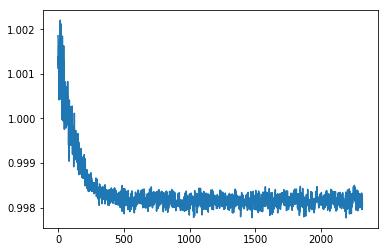

In [37]:
plt.plot(monitor["loss"]);

In [ ]:
monitor["loss"][:500]

In [57]:
save_entire_model(model, "../saved_models/swiki_full-model_lr-{}_bs-{}_lmbda-{}.pth".format(1e-3, batch_size, wd))
save_model_state(model, "../saved_models/swiki_model-state_lr-{}_bs-{}_lmbda-{}.pth".format(1e-3, batch_size, wd))

In [43]:
def y_predict(data, model):
    logging.info("Predicting for validation model...")
    with torch.no_grad():
        for index, (doc_vec, label_ids, doc_id, y_true) in enumerate(tqdm(data)):

            print(doc_vec.shape)
            
            score = model.linear.forward(doc_vec)
            print(score[0])            
            y_index = np.argmax(score, 1)

            break
    return y_index

y_predict(validation_loader, model)

INFO:root:Predicting for validation model...
  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

torch.Size([40, 300])
torch.Size([40])
torch.Size([40, 101])


tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33])

In [39]:
def gather_outputs(data, model):
    logging.info("Evaluating ...")
    yy_t = []
    yy_p = []
    with torch.no_grad():
        for index, (doc_vec, label_ids, doc_id, yin) in enumerate(tqdm(data)):
            
            
            W_params = list(model.parameters())[0].data.squeeze()
            
            score = model.linear.forward(doc_vec)
            score = score.detach().numpy()
            y_index = np.argmax(score, 1)
            
            sc = torch.sigmoid(torch.from_numpy(score))
            sorted_, indices  = torch.sort(sc)
            mid = (sorted_[1:] + sorted_[:-1])/2
            best_thresh, best_f1 = sorted_[0], 0
            y_true = torch.where(yin > 0, torch.Tensor([1]), torch.Tensor([0])).int()
            y_true = y_true.numpy()

            for threshold in mid:
                y_pred = np.array(sc > threshold).astype(int)
                f1 = f1_score(y_true, y_pred, average="micro")

                if f1 > best_f1:
                    best_thresh = threshold
                    best_f1 = f1
            
            y_pred = np.array(sc > best_thresh).astype(int)
            
            yy_t.append(y_true)
            yy_p.append(y_pred)
            
    yy_t = np.vstack(yy_t)
    yy_p = np.vstack(yy_p)
    return yy_t, yy_p

y1, y2 = gather_outputs(validation_loader, model)
# f1_score(y1, y2, average="micro")

INFO:root:Evaluating ...
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:20<00:00,  6.11it/s]


In [40]:
print(classification_report(y1, y2))

              precision    recall  f1-score   support

           0       0.03      0.20      0.06       129
           1       0.02      0.23      0.04        73
           2       0.03      0.16      0.05       153
           3       0.00      0.10      0.01        31
           4       0.17      0.39      0.23       736
           5       0.09      0.22      0.13       410
           6       0.02      0.19      0.04        72
           7       0.08      0.21      0.11       347
           8       0.00      0.12      0.00         8
           9       0.04      0.16      0.07       206
          10       0.02      0.13      0.03        75
          11       0.01      0.10      0.02        48
          12       0.00      0.08      0.00        13
          13       0.02      0.20      0.03        46
          14       0.06      0.20      0.09       244
          15       0.05      0.16      0.07       206
          16       0.01      0.24      0.02        25
          17       0.01    

In [41]:
train_data.iter.lib_data.binarizer.inverse_transform(y1)[:5]

[(22.0, 34.0, 71.0, 77.0), (), (94.0, 103.0), (15.0, 16.0, 34.0), (71.0, 84.0)]

In [42]:
train_data.iter.MLbin.inverse_transform(y2)[:5] #scoring function

[(5.0, 6.0, 34.0, 71.0), (34.0,), (5.0, 34.0), (34.0,), (34.0, 71.0)]

In [44]:
mod = nn.Linear(20, 5) # predict logits for 5 classes
x = torch.randn(1, 20)
y = torch.Tensor([[1., 0., 1., 0., 0.]]) # get classA and classC as active

criterio = nn.BCEWithLogitsLoss()
optimize = torch.optim.SGD(mod.parameters(), lr=1e-1)

for epoch in range(10):
    optimize.zero_grad()
    output = mod(x)
    print(output.data.squeeze())
    los = criterio(output, y)
    los.backward()
    optimize.step()
    print('Loss: {:.3f}'.format(los.item()))

tensor([ 0.2298,  0.3665, -0.4045,  0.7686,  0.4514])
Loss: 0.897
tensor([ 0.4765,  0.0375, -0.0704,  0.3880,  0.1110])
Loss: 0.716
tensor([ 0.6899, -0.2463,  0.2180,  0.0561, -0.1830])
Loss: 0.580
tensor([ 0.8760, -0.4907,  0.4663, -0.2303, -0.4362])
Loss: 0.479
tensor([ 1.0398, -0.7023,  0.6811, -0.4769, -0.6549])
Loss: 0.403
tensor([ 1.1853, -0.8869,  0.8683, -0.6903, -0.8454])
Loss: 0.345
tensor([ 1.3157, -1.0494,  1.0330, -0.8764, -1.0128])
Loss: 0.300
tensor([ 1.4336, -1.1939,  1.1792, -1.0401, -1.1612])
Loss: 0.264
tensor([ 1.5408, -1.3235,  1.3103, -1.1856, -1.2940])
Loss: 0.236
tensor([ 1.6391, -1.4406,  1.4286, -1.3160, -1.4139])
Loss: 0.212
